# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [7]:
labels.shape

(7591, 2)

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

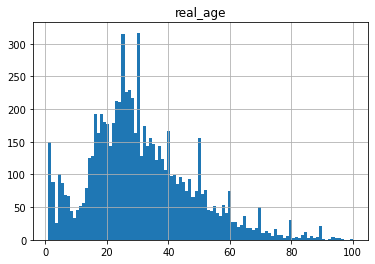

In [4]:
labels.hist(bins=100)

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


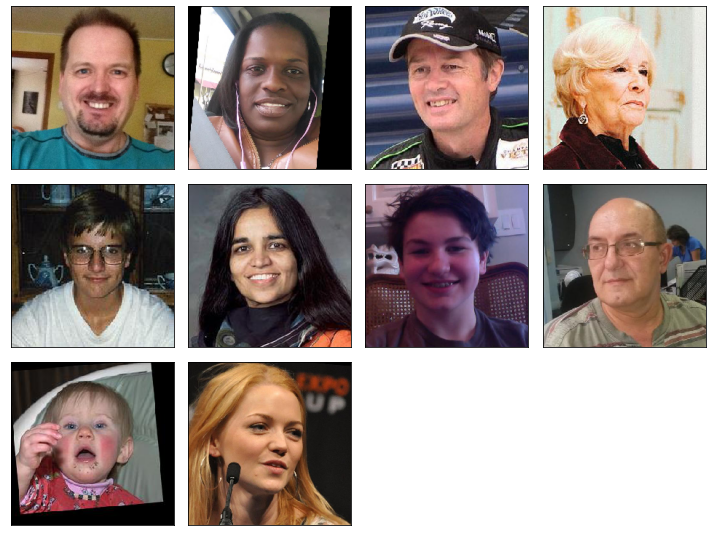

In [6]:
# Выведем 10 фото
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод** 
1) В датасете 7591 фотографий

2) Большая часть возарста людей находится в диапазоне от 21 до 40 лет

3) Есть ЧБ фотографии, под углом, разных размеров, к тому же есть фото с лишними объектами перед лицом(жвачка, микрофон и пр.)

4) В целом общая ориненатция фотографий выстроена правильно, но опять же некоторые под довльно сильным углом

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 116s - loss: 204.8660 - mae: 10.4056 - val_loss: 632.3849 - val_mae: 20.0877
Epoch 2/10
356/356 - 40s - loss: 87.3944 - mae: 7.0922 - val_loss: 123.1090 - val_mae: 8.2698
Epoch 3/10
356/356 - 40s - loss: 56.3617 - mae: 5.7558 - val_loss: 83.0355 - val_mae: 6.7989
Epoch 4/10
356/356 - 40s - loss: 41.4288 - mae: 4.9632 - val_loss: 98.0594 - val_mae: 7.4277
Epoch 5/10
356/356 - 40s - loss: 31.8802 - mae: 4.3635 - val_loss: 70.8377 - val_mae: 6.3042
Epoch 6/10
356/356 - 40s - loss: 26.1412 - mae: 3.9406 - val_loss: 74.3797 - val_mae: 6.3822
Epoch 7/10
356/356 - 40s - loss: 21.7432 - mae: 3.5440 - val_loss: 92.1918 - val_mae: 7.1217
Epoch 8/10
356/356 - 40s - loss: 19.7696 - mae: 3.3835 - val_loss: 67.2342 - val_mae: 6.1477
Epoch 9/10
356/356 - 40s - loss: 15.3840 - mae: 3.0008 - val_loss: 74.9610 - val_mae: 6.4470
Epoch 10/10
356/356 - 40s - loss: 14.0712 - mae: 2.8653 - val_loss: 66.8269 - val_mae: 6.0457

119/119 - 10s - loss: 66.8269 - mae: 6.0457
Test MAE: 6.0457

```

**Вывод**
1) Была использована модель сверточной нейронной сети на ResNet50

2) MAE за 10 эпох удалось уменьшить с 10.4 до 2.8, дальше возможно будет еще меньше

3) Выборка не такая большая, следовательно времени ушло не так много н обучение

## Анализ обученной модели

1) Использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью

2) Погрешность в 6 лет не такая "значимая" при определении возраста (за исколючением примера с продажей алкоголя)

3) Полученная модель вполне может решить поставленную бизнесом задачу, но всегда есть куда развиваться

4) ResNet — это глубокая сеть, которая применяет skip-connections, свёртки небольшого размера и bottleneck-блоки. На большинстве задач она работает лучше других архитектур, следовательно тут мы ее и использовали. В ResNet50 - 50 это колличество слоев.


## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы